In [ ]:
!pip install shap


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tabulate import tabulate
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
attributes = pd.read_excel('/content/drive/MyDrive/airline_data/bookings_flownAug_Dec23.xlsx')
attributes.columns

Index(['pnr', 'segment_id', 'created_date', 'operating_flight_number',
       'channel', 'departure_date', 'confirmed_air_fare', 'from_airport',
       'to_airport', 'gender', 'age', 'nationality', 'payment_method', 'std',
       'capacity'],
      dtype='object')

In [ ]:
display(attributes)

,pnr,segment_id,created_date,operating_flight_number,channel,departure_date,confirmed_air_fare,from_airport,to_airport,gender,age,nationality,payment_method,std,capacity
0,000I4B,000I4B2992,2023-05-17 14:44:48.000,215,WEB,2023-08-11,53.00,HER,ATH,M,15.0,United Kingdom,MasterCard,2023-08-11 18:10:00,174.0
1,000I4B,000I4B2993,2023-05-17 14:44:48.000,215,WEB,2023-08-11,53.00,HER,ATH,F,43.0,United Kingdom,MasterCard,2023-08-11 18:10:00,174.0
2,000I4B,000I4B2994,2023-05-17 14:44:48.000,215,WEB,2023-08-11,53.00,HER,ATH,F,18.0,United Kingdom,MasterCard,2023-08-11 18:10:00,174.0
3,003PQG,003PQG2991,2023-08-16 22:26:50.000,390,API,2023-08-17,82.00,ATH,SKG,F,30.0,Greece,VISA,2023-08-17 22:55:00,180.0
4,006RBO,006RBO2993,2023-08-07 13:27:49.000,216,standard,2023-09-06,19.00,ATH,HER,NaN,NaN,NaN,MasterCard,2023-09-06 20:20:00,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130256,ZZSLWT,ZZSLWT2993,2023-08-16 13:29:06.000,382,standard,2023-10-07,29.00,ATH,SKG,M,2022.0,Greece,VISA,2023-10-07 10:30:00,72.0
130257,ZZUXRB,ZZUXRB2991,2023-06-08 09:02:50.000,384,GDS,2023-08-21,28.95,ATH,SKG,F,0.0,NaN,E-TICKET,2023-08-21 17:10:00,180.0
130258,ZZUXRB,ZZUXRB2992,2023-06-08 09:02:51.000,385,GDS,2023-08-26,29.85,SKG,ATH,F,0.0,NaN,E-TICKET,2023-08-26 18:40:00,186.0
130259,ZZYID5,ZZYID52991,2023-07-04 11:28:03.000,603,WEB,2023-09-08,35.00,LCA,ATH,F,32.0,Cyprus,VISA,2023-09-08 20:00:00,186.0


In [ ]:
attributes.rename(columns={'std':'dep', 'created_date':'cre'}, inplace = True)

In [ ]:
null_count = attributes.isnull().sum()
print(null_count)

pnr                            0
segment_id                     0
cre                            0
operating_flight_number        0
channel                        0
departure_date                 0
confirmed_air_fare             0
from_airport                   0
to_airport                     0
gender                     11634
age                        18709
nationality                37830
payment_method              5097
dep                            5
capacity                       5
dtype: int64


In [ ]:
attributes = attributes.dropna(subset=['dep'])
null_count = attributes.isnull().sum()
print(null_count)

pnr                            0
segment_id                     0
cre                            0
operating_flight_number        0
channel                        0
departure_date                 0
confirmed_air_fare             0
from_airport                   0
to_airport                     0
gender                     11634
age                        18709
nationality                37830
payment_method              5097
dep                            0
capacity                       0
dtype: int64


In [ ]:
attributes['days_left'] = (pd.to_datetime(attributes['dep']) - pd.to_datetime(attributes['cre'])).dt.days

# Convert and update the format in ATH_HER_searches
attributes['cre'] = pd.to_datetime(attributes['cre']).dt.date

attributes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pnr,segment_id,cre,operating_flight_number,channel,departure_date,confirmed_air_fare,from_airport,to_airport,gender,age,nationality,payment_method,dep,capacity,days_left
0,000I4B,000I4B2992,2023-05-17,215,WEB,2023-08-11,53.00,HER,ATH,M,15.0,United Kingdom,MasterCard,2023-08-11 18:10:00,174.0,86
1,000I4B,000I4B2993,2023-05-17,215,WEB,2023-08-11,53.00,HER,ATH,F,43.0,United Kingdom,MasterCard,2023-08-11 18:10:00,174.0,86
2,000I4B,000I4B2994,2023-05-17,215,WEB,2023-08-11,53.00,HER,ATH,F,18.0,United Kingdom,MasterCard,2023-08-11 18:10:00,174.0,86
3,003PQG,003PQG2991,2023-08-16,390,API,2023-08-17,82.00,ATH,SKG,F,30.0,Greece,VISA,2023-08-17 22:55:00,180.0,1
4,006RBO,006RBO2993,2023-08-07,216,standard,2023-09-06,19.00,ATH,HER,NaN,NaN,NaN,MasterCard,2023-09-06 20:20:00,186.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130256,ZZSLWT,ZZSLWT2993,2023-08-16,382,standard,2023-10-07,29.00,ATH,SKG,M,2022.0,Greece,VISA,2023-10-07 10:30:00,72.0,51
130257,ZZUXRB,ZZUXRB2991,2023-06-08,384,GDS,2023-08-21,28.95,ATH,SKG,F,0.0,NaN,E-TICKET,2023-08-21 17:10:00,180.0,74
130258,ZZUXRB,ZZUXRB2992,2023-06-08,385,GDS,2023-08-26,29.85,SKG,ATH,F,0.0,NaN,E-TICKET,2023-08-26 18:40:00,186.0,79
130259,ZZYID5,ZZYID52991,2023-07-04,603,WEB,2023-09-08,35.00,LCA,ATH,F,32.0,Cyprus,VISA,2023-09-08 20:00:00,186.0,66


In [ ]:
attribute_general = attributes.drop(columns=['segment_id','channel','gender','nationality','payment_method','operating_flight_number','age'])
attribute_general


,pnr,cre,departure_date,confirmed_air_fare,from_airport,to_airport,dep,capacity,days_left
0,000I4B,2023-05-17,2023-08-11,53.00,HER,ATH,2023-08-11 18:10:00,174.0,86
1,000I4B,2023-05-17,2023-08-11,53.00,HER,ATH,2023-08-11 18:10:00,174.0,86
2,000I4B,2023-05-17,2023-08-11,53.00,HER,ATH,2023-08-11 18:10:00,174.0,86
3,003PQG,2023-08-16,2023-08-17,82.00,ATH,SKG,2023-08-17 22:55:00,180.0,1
4,006RBO,2023-08-07,2023-09-06,19.00,ATH,HER,2023-09-06 20:20:00,186.0,30
...,...,...,...,...,...,...,...,...,...
130256,ZZSLWT,2023-08-16,2023-10-07,29.00,ATH,SKG,2023-10-07 10:30:00,72.0,51
130257,ZZUXRB,2023-06-08,2023-08-21,28.95,ATH,SKG,2023-08-21 17:10:00,180.0,74
130258,ZZUXRB,2023-06-08,2023-08-26,29.85,SKG,ATH,2023-08-26 18:40:00,186.0,79
130259,ZZYID5,2023-07-04,2023-09-08,35.00,LCA,ATH,2023-09-08 20:00:00,186.0,66


In [ ]:
attribute_general = attribute_general.sort_values(by=['from_airport', 'to_airport', 'dep', 'days_left'])
display(attribute_general)


,pnr,cre,departure_date,confirmed_air_fare,from_airport,to_airport,dep,capacity,days_left
34440,9G2ZBT,2023-07-30,2023-08-01,142.00,ATH,HER,2023-08-01 07:30:00,174.0,1
78979,KUNHMZ,2023-07-30,2023-08-01,49.00,ATH,HER,2023-08-01 07:30:00,174.0,1
78980,KUNHMZ,2023-07-30,2023-08-01,49.00,ATH,HER,2023-08-01 07:30:00,174.0,1
17887,4SMLGS,2023-07-29,2023-08-01,90.00,ATH,HER,2023-08-01 07:30:00,174.0,2
25101,6VNTOM,2023-07-29,2023-08-01,59.00,ATH,HER,2023-08-01 07:30:00,174.0,2
...,...,...,...,...,...,...,...,...,...
37504,A3RJ08,2023-07-26,2023-12-30,24.99,SKG,ATH,2023-12-30 21:35:00,186.0,157
23475,6GAUE4,2023-03-14,2023-12-30,25.00,SKG,ATH,2023-12-30 21:35:00,186.0,291
24051,6GAUE4,2023-03-14,2023-12-30,25.00,SKG,ATH,2023-12-30 21:35:00,186.0,291
96741,RMXI6L,2023-07-31,2023-12-31,24.99,SKG,ATH,2023-12-31 09:30:00,186.0,152


In [ ]:
# Group by and aggregate
agg_df = attribute_general.groupby(['dep', 'from_airport', 'to_airport', 'days_left']).agg(number_of_bookings_on_given_day=('pnr', 'nunique'), number_of_seatsbooked_on_given_day=('pnr', 'size'),mean_confirmed_fare=pd.NamedAgg(column='confirmed_air_fare', aggfunc='mean')).reset_index()

# Sort values for cumulative calculation
agg_df = agg_df.sort_values(by=['dep', 'from_airport', 'to_airport', 'days_left'], ascending=[True, True, True, False])

# Calculate cumulative sum for seats and bookings
agg_df['cumulative number of seats booked'] = agg_df.groupby(['dep', 'from_airport', 'to_airport'])['number_of_seatsbooked_on_given_day'].cumsum()
agg_df['cumulative number of bookings'] = agg_df.groupby(['dep', 'from_airport', 'to_airport'])['number_of_bookings_on_given_day'].cumsum()

display(agg_df)


,dep,from_airport,to_airport,days_left,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings
33,2023-08-01 07:00:00,LCA,ATH,182,2,4,99.00,4,2
32,2023-08-01 07:00:00,LCA,ATH,119,1,2,87.00,6,3
31,2023-08-01 07:00:00,LCA,ATH,118,1,1,99.00,7,4
30,2023-08-01 07:00:00,LCA,ATH,94,2,3,87.00,10,6
29,2023-08-01 07:00:00,LCA,ATH,93,3,3,87.00,13,9
...,...,...,...,...,...,...,...,...,...
44773,2023-12-31 20:15:00,ATH,HER,161,1,3,15.00,3,1
44772,2023-12-31 20:15:00,ATH,HER,143,1,1,32.00,4,2
44774,2023-12-31 20:30:00,ATH,LCA,214,1,16,25.21,16,1
44775,2023-12-31 21:35:00,SKG,ATH,296,1,1,25.00,1,1


In [ ]:
# Merging the grouped data back to original dataframe
df_merged = pd.merge(attribute_general, agg_df, on=['dep', 'from_airport', 'to_airport','days_left'], how='left')

# Keeping only relevant columns and dropping duplicates
result_df = df_merged[['from_airport', 'to_airport', 'dep', 'capacity', 'days_left', 'cre','mean_confirmed_fare','cumulative number of seats booked','cumulative number of bookings','number_of_bookings_on_given_day','number_of_seatsbooked_on_given_day']].drop_duplicates()

display(result_df)

,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day
0,ATH,HER,2023-08-01 07:30:00,174.0,1,2023-07-30,80.000000,179,95,2,3
3,ATH,HER,2023-08-01 07:30:00,174.0,2,2023-07-29,68.971818,176,93,6,11
14,ATH,HER,2023-08-01 07:30:00,174.0,3,2023-07-28,67.777778,165,87,7,9
19,ATH,HER,2023-08-01 07:30:00,174.0,3,2023-07-29,67.777778,165,87,7,9
23,ATH,HER,2023-08-01 07:30:00,174.0,4,2023-07-27,55.796000,156,80,6,15
...,...,...,...,...,...,...,...,...,...,...,...
130250,SKG,ATH,2023-12-30 18:25:00,186.0,169,2023-07-14,29.000000,1,1,1,1
130251,SKG,ATH,2023-12-30 21:35:00,186.0,157,2023-07-26,24.990000,3,2,1,1
130252,SKG,ATH,2023-12-30 21:35:00,186.0,291,2023-03-14,25.000000,2,1,1,2
130254,SKG,ATH,2023-12-31 09:30:00,186.0,152,2023-07-31,24.990000,1,1,1,1


In [ ]:
result_df.columns

Index(['from_airport', 'to_airport', 'dep', 'capacity', 'days_left', 'cre',
       'mean_confirmed_fare', 'cumulative number of seats booked',
       'cumulative number of bookings', 'number_of_bookings_on_given_day',
       'number_of_seatsbooked_on_given_day'],
      dtype='object')

In [ ]:
# Extract the unique flights
unique_flights = attribute_general[['from_airport', 'to_airport', 'dep']].drop_duplicates()

# Count the number of unique flights
num_unique_flights = unique_flights.shape[0]

print(f"Number of unique flights in the dataset: {num_unique_flights}")


Number of unique flights in the dataset: 3054


In [ ]:
# Filter rows where cumulative_seats is greater than capacity
overbooked_df = result_df[result_df['cumulative number of seats booked'] > result_df['capacity']]
overbooked_df = overbooked_df.sort_values(by=['from_airport', 'to_airport','dep', 'days_left'], ascending=[True, True, True, True])

overbooked_df['capacity']= overbooked_df['capacity'].astype(int)

display(overbooked_df)
display(overbooked_df[['from_airport','to_airport','dep','days_left','cumulative number of seats booked','capacity']])

,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day
0,ATH,HER,2023-08-01 07:30:00,174,1,2023-07-30,80.000000,179,95,2,3
3,ATH,HER,2023-08-01 07:30:00,174,2,2023-07-29,68.971818,176,93,6,11
950,ATH,HER,2023-08-03 07:30:00,174,0,2023-08-02,125.500000,178,103,2,2
952,ATH,HER,2023-08-03 07:30:00,174,1,2023-08-01,58.942500,176,101,9,12
1470,ATH,HER,2023-08-04 07:30:00,180,0,2023-08-03,97.100000,183,111,9,10
1477,ATH,HER,2023-08-04 07:30:00,180,0,2023-08-04,97.100000,183,111,9,10
1823,ATH,HER,2023-08-04 20:20:00,230,0,2023-08-04,109.981429,233,142,9,14
1834,ATH,HER,2023-08-04 20:20:00,230,0,2023-08-03,109.981429,233,142,9,14
2238,ATH,HER,2023-08-05 07:30:00,186,0,2023-08-04,142.000000,191,104,2,2
2240,ATH,HER,2023-08-05 07:30:00,186,1,2023-08-03,118.174000,189,102,3,10


,from_airport,to_airport,dep,days_left,cumulative number of seats booked,capacity
0,ATH,HER,2023-08-01 07:30:00,1,179,174
3,ATH,HER,2023-08-01 07:30:00,2,176,174
950,ATH,HER,2023-08-03 07:30:00,0,178,174
952,ATH,HER,2023-08-03 07:30:00,1,176,174
1470,ATH,HER,2023-08-04 07:30:00,0,183,180
1477,ATH,HER,2023-08-04 07:30:00,0,183,180
1823,ATH,HER,2023-08-04 20:20:00,0,233,230
1834,ATH,HER,2023-08-04 20:20:00,0,233,230
2238,ATH,HER,2023-08-05 07:30:00,0,191,186
2240,ATH,HER,2023-08-05 07:30:00,1,189,186


In [ ]:
overbooked_df


,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day
0,ATH,HER,2023-08-01 07:30:00,174,1,2023-07-30,80.000000,179,95,2,3
3,ATH,HER,2023-08-01 07:30:00,174,2,2023-07-29,68.971818,176,93,6,11
950,ATH,HER,2023-08-03 07:30:00,174,0,2023-08-02,125.500000,178,103,2,2
952,ATH,HER,2023-08-03 07:30:00,174,1,2023-08-01,58.942500,176,101,9,12
1470,ATH,HER,2023-08-04 07:30:00,180,0,2023-08-03,97.100000,183,111,9,10
1477,ATH,HER,2023-08-04 07:30:00,180,0,2023-08-04,97.100000,183,111,9,10
1823,ATH,HER,2023-08-04 20:20:00,230,0,2023-08-04,109.981429,233,142,9,14
1834,ATH,HER,2023-08-04 20:20:00,230,0,2023-08-03,109.981429,233,142,9,14
2238,ATH,HER,2023-08-05 07:30:00,186,0,2023-08-04,142.000000,191,104,2,2
2240,ATH,HER,2023-08-05 07:30:00,186,1,2023-08-03,118.174000,189,102,3,10


In [ ]:
# replace the overbooked flight with maximum capacity

#Convert the 'capacity' column to integer
overbooked_df['capacity'] = overbooked_df['capacity'].astype(int)

# Create a new dataframe where cumulative number of seats booked is replaced by capacity for overbooked rows
replaced_overbooked_df = overbooked_df.copy()
replaced_overbooked_df['cumulative number of seats booked'] = replaced_overbooked_df['capacity']

# Now, replace the overbooked rows in result_df with the rows from replaced_overbooked_df
result_df.update(replaced_overbooked_df)

result_df

,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day
0,ATH,HER,2023-08-01 07:30:00,174.0,1.0,2023-07-30,80.000000,174.0,95.0,2.0,3.0
3,ATH,HER,2023-08-01 07:30:00,174.0,2.0,2023-07-29,68.971818,174.0,93.0,6.0,11.0
14,ATH,HER,2023-08-01 07:30:00,174.0,3.0,2023-07-28,67.777778,165.0,87.0,7.0,9.0
19,ATH,HER,2023-08-01 07:30:00,174.0,3.0,2023-07-29,67.777778,165.0,87.0,7.0,9.0
23,ATH,HER,2023-08-01 07:30:00,174.0,4.0,2023-07-27,55.796000,156.0,80.0,6.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...
130250,SKG,ATH,2023-12-30 18:25:00,186.0,169.0,2023-07-14,29.000000,1.0,1.0,1.0,1.0
130251,SKG,ATH,2023-12-30 21:35:00,186.0,157.0,2023-07-26,24.990000,3.0,2.0,1.0,1.0
130252,SKG,ATH,2023-12-30 21:35:00,186.0,291.0,2023-03-14,25.000000,2.0,1.0,1.0,2.0
130254,SKG,ATH,2023-12-31 09:30:00,186.0,152.0,2023-07-31,24.990000,1.0,1.0,1.0,1.0


In [ ]:
# Extract the unique flights
unique_flights_overbooked = overbooked_df[['from_airport', 'to_airport', 'dep']].drop_duplicates()
display(unique_flights_overbooked)
# Count the number of unique flights
unique_flights_overbooked = unique_flights_overbooked.shape[0]

print(f"Number of unique overbooked flights in the dataset: {unique_flights_overbooked}")


,from_airport,to_airport,dep
0,ATH,HER,2023-08-01 07:30:00
950,ATH,HER,2023-08-03 07:30:00
1470,ATH,HER,2023-08-04 07:30:00
1823,ATH,HER,2023-08-04 20:20:00
2238,ATH,HER,2023-08-05 07:30:00
5239,ATH,HER,2023-08-11 07:30:00
5803,ATH,HER,2023-08-11 22:40:00
6396,ATH,HER,2023-08-13 07:30:00
71566,HER,ATH,2023-08-20 21:50:00
72212,HER,ATH,2023-08-21 21:45:00


Number of unique overbooked flights in the dataset: 13


In [ ]:
# Assuming the 'capacity' column is of numeric type. If not, first convert it.
result_df['capacity'] = result_df['capacity'].astype(float)

# Compute the load factor
#result_df['load factor'] = result_df['cumulative number of seats booked'] / result_df['capacity']

# load factor in percentage format:
result_df['load factor'] = (result_df['cumulative number of seats booked'] / result_df['capacity']) * 100
result_df

,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day,load factor
0,ATH,HER,2023-08-01 07:30:00,174.0,1.0,2023-07-30,80.000000,174.0,95.0,2.0,3.0,100.000000
3,ATH,HER,2023-08-01 07:30:00,174.0,2.0,2023-07-29,68.971818,174.0,93.0,6.0,11.0,100.000000
14,ATH,HER,2023-08-01 07:30:00,174.0,3.0,2023-07-28,67.777778,165.0,87.0,7.0,9.0,94.827586
19,ATH,HER,2023-08-01 07:30:00,174.0,3.0,2023-07-29,67.777778,165.0,87.0,7.0,9.0,94.827586
23,ATH,HER,2023-08-01 07:30:00,174.0,4.0,2023-07-27,55.796000,156.0,80.0,6.0,15.0,89.655172
...,...,...,...,...,...,...,...,...,...,...,...,...
130250,SKG,ATH,2023-12-30 18:25:00,186.0,169.0,2023-07-14,29.000000,1.0,1.0,1.0,1.0,0.537634
130251,SKG,ATH,2023-12-30 21:35:00,186.0,157.0,2023-07-26,24.990000,3.0,2.0,1.0,1.0,1.612903
130252,SKG,ATH,2023-12-30 21:35:00,186.0,291.0,2023-03-14,25.000000,2.0,1.0,1.0,2.0,1.075269
130254,SKG,ATH,2023-12-31 09:30:00,186.0,152.0,2023-07-31,24.990000,1.0,1.0,1.0,1.0,0.537634


In [ ]:
result_df = result_df.sort_values(by=['dep', 'from_airport', 'to_airport', 'days_left'], ascending=[True, True, True, False])
result_df['baseline'] = result_df['number_of_bookings_on_given_day'].shift(1)
result_df['baseline'].fillna(0, inplace=True)
result_df

,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day,load factor,baseline
87144,LCA,ATH,2023-08-01 07:00:00,230.0,182.0,2023-01-30,99.00,4.0,2.0,2.0,4.0,1.739130,0.0
87142,LCA,ATH,2023-08-01 07:00:00,230.0,119.0,2023-04-03,87.00,6.0,3.0,1.0,2.0,2.608696,2.0
87141,LCA,ATH,2023-08-01 07:00:00,230.0,118.0,2023-04-05,99.00,7.0,4.0,1.0,1.0,3.043478,1.0
87138,LCA,ATH,2023-08-01 07:00:00,230.0,94.0,2023-04-28,87.00,10.0,6.0,2.0,3.0,4.347826,1.0
87135,LCA,ATH,2023-08-01 07:00:00,230.0,93.0,2023-04-29,87.00,13.0,9.0,3.0,3.0,5.652174,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20394,ATH,HER,2023-12-31 20:15:00,186.0,161.0,2023-07-23,15.00,3.0,1.0,1.0,3.0,1.612903,1.0
20393,ATH,HER,2023-12-31 20:15:00,186.0,143.0,2023-08-10,32.00,4.0,2.0,1.0,1.0,2.150538,1.0
43617,ATH,LCA,2023-12-31 20:30:00,186.0,214.0,2023-05-31,25.21,16.0,1.0,1.0,16.0,8.602151,1.0
130255,SKG,ATH,2023-12-31 21:35:00,186.0,296.0,2023-03-10,25.00,1.0,1.0,1.0,1.0,0.537634,1.0


In [ ]:
result_df['dep'] = pd.to_datetime(result_df['dep'])

# Extract dep_time, dep_date, and dep_month
result_df['departure_time'] = result_df['dep'].dt.strftime('%H:%M')

result_df['departure_day'] = result_df['dep'].dt.day
result_df['departure_month'] = result_df['dep'].dt.strftime('%B')
result_df['departure_date'] = result_df['dep'].dt.strftime('%Y-%m-%d')


# Determine if the date is a weekday or weekend
result_df['day_type_weekend'] = result_df['dep'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

display(result_df.head())



,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day,load factor,baseline,departure_time,departure_day,departure_month,departure_date,day_type_weekend
87144,LCA,ATH,2023-08-01 07:00:00,230.0,182.0,2023-01-30,99.0,4.0,2.0,2.0,4.0,1.739130,0.0,07:00,1,August,2023-08-01,0
87142,LCA,ATH,2023-08-01 07:00:00,230.0,119.0,2023-04-03,87.0,6.0,3.0,1.0,2.0,2.608696,2.0,07:00,1,August,2023-08-01,0
87141,LCA,ATH,2023-08-01 07:00:00,230.0,118.0,2023-04-05,99.0,7.0,4.0,1.0,1.0,3.043478,1.0,07:00,1,August,2023-08-01,0
87138,LCA,ATH,2023-08-01 07:00:00,230.0,94.0,2023-04-28,87.0,10.0,6.0,2.0,3.0,4.347826,1.0,07:00,1,August,2023-08-01,0
87135,LCA,ATH,2023-08-01 07:00:00,230.0,93.0,2023-04-29,87.0,13.0,9.0,3.0,3.0,5.652174,2.0,07:00,1,August,2023-08-01,0


In [ ]:
result_df['departure_hour'] = result_df['departure_time'].astype(str).str.split(':').str[0].astype(int)

result_df

,from_airport,to_airport,dep,capacity,days_left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day,load factor,baseline,departure_time,departure_day,departure_month,departure_date,day_type_weekend,departure_hour
87144,LCA,ATH,2023-08-01 07:00:00,230.0,182.0,2023-01-30,99.00,4.0,2.0,2.0,4.0,1.739130,0.0,07:00,1,August,2023-08-01,0,7
87142,LCA,ATH,2023-08-01 07:00:00,230.0,119.0,2023-04-03,87.00,6.0,3.0,1.0,2.0,2.608696,2.0,07:00,1,August,2023-08-01,0,7
87141,LCA,ATH,2023-08-01 07:00:00,230.0,118.0,2023-04-05,99.00,7.0,4.0,1.0,1.0,3.043478,1.0,07:00,1,August,2023-08-01,0,7
87138,LCA,ATH,2023-08-01 07:00:00,230.0,94.0,2023-04-28,87.00,10.0,6.0,2.0,3.0,4.347826,1.0,07:00,1,August,2023-08-01,0,7
87135,LCA,ATH,2023-08-01 07:00:00,230.0,93.0,2023-04-29,87.00,13.0,9.0,3.0,3.0,5.652174,2.0,07:00,1,August,2023-08-01,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20394,ATH,HER,2023-12-31 20:15:00,186.0,161.0,2023-07-23,15.00,3.0,1.0,1.0,3.0,1.612903,1.0,20:15,31,December,2023-12-31,1,20
20393,ATH,HER,2023-12-31 20:15:00,186.0,143.0,2023-08-10,32.00,4.0,2.0,1.0,1.0,2.150538,1.0,20:15,31,December,2023-12-31,1,20
43617,ATH,LCA,2023-12-31 20:30:00,186.0,214.0,2023-05-31,25.21,16.0,1.0,1.0,16.0,8.602151,1.0,20:30,31,December,2023-12-31,1,20
130255,SKG,ATH,2023-12-31 21:35:00,186.0,296.0,2023-03-10,25.00,1.0,1.0,1.0,1.0,0.537634,1.0,21:35,31,December,2023-12-31,1,21


In [ ]:
result_df.columns

Index(['from_airport', 'to_airport', 'dep', 'capacity', 'days_left', 'cre',
       'mean_confirmed_fare', 'cumulative number of seats booked',
       'cumulative number of bookings', 'number_of_bookings_on_given_day',
       'number_of_seatsbooked_on_given_day', 'load factor', 'baseline',
       'departure_time', 'departure_day', 'departure_month', 'departure_date',
       'day_type_weekend', 'departure_hour'],
      dtype='object')

# add competitor's price


In [ ]:
pivot_df = pd.read_csv('//content/drive/MyDrive/airline_data/AA_meangrossfare_csv')
pivot_df


,SiteName,DepartureDate,SourceAirport,DestinationAirport,Departure_Time,Arrival_Time,days left,GrossFare
0,AegeanAirways_Y,2023-05-03,ATH,HER,06:50,07:40,0,68.530
1,AegeanAirways_Y,2023-05-03,ATH,HER,10:00,10:50,0,89.455
2,AegeanAirways_Y,2023-05-03,ATH,HER,13:10,14:05,0,89.455
3,AegeanAirways_Y,2023-05-03,ATH,HER,16:25,17:20,0,102.490
4,AegeanAirways_Y,2023-05-03,ATH,HER,19:40,20:35,0,78.230
...,...,...,...,...,...,...,...,...
401561,AegeanAirways_Y,2023-12-20,SKG,ATH,14:45,15:40,120,55.770
401562,AegeanAirways_Y,2023-12-20,SKG,ATH,18:05,19:00,120,66.930
401563,AegeanAirways_Y,2023-12-20,SKG,ATH,19:45,20:40,120,66.930
401564,AegeanAirways_Y,2023-12-20,SKG,ATH,21:30,22:25,120,55.770


In [ ]:
import pandas as pd

# Rename the columns in df2 to match df1 for a consistent merge
result_df.rename(columns={
    'from_airport': 'SourceAirport',
    'to_airport': 'DestinationAirport',
    'departure_date': 'DepartureDate',
    'days_left': 'days left',
    'departure_time': 'Departure_Time'
}, inplace=True)


In [ ]:
print(pivot_df.columns)
print(result_df.columns)

Index(['SiteName', 'DepartureDate', 'SourceAirport', 'DestinationAirport',
       'Departure_Time', 'Arrival_Time', 'days left', 'GrossFare'],
      dtype='object')
Index(['SourceAirport', 'DestinationAirport', 'dep', 'capacity', 'days left',
       'cre', 'mean_confirmed_fare', 'cumulative number of seats booked',
       'cumulative number of bookings', 'number_of_bookings_on_given_day',
       'number_of_seatsbooked_on_given_day', 'load factor', 'baseline',
       'Departure_Time', 'departure_day', 'departure_month', 'DepartureDate',
       'day_type_weekend', 'departure_hour'],
      dtype='object')


In [ ]:
display(pivot_df.head())
display(result_df.head())

,SiteName,DepartureDate,SourceAirport,DestinationAirport,Departure_Time,Arrival_Time,days left,GrossFare
0,AegeanAirways_Y,2023-05-03,ATH,HER,06:50,07:40,0,68.530
1,AegeanAirways_Y,2023-05-03,ATH,HER,10:00,10:50,0,89.455
2,AegeanAirways_Y,2023-05-03,ATH,HER,13:10,14:05,0,89.455
3,AegeanAirways_Y,2023-05-03,ATH,HER,16:25,17:20,0,102.490
4,AegeanAirways_Y,2023-05-03,ATH,HER,19:40,20:35,0,78.230


,SourceAirport,DestinationAirport,dep,capacity,days left,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day,load factor,baseline,Departure_Time,departure_day,departure_month,DepartureDate,day_type_weekend,departure_hour
87144,LCA,ATH,2023-08-01 07:00:00,230.0,182.0,2023-01-30,99.0,4.0,2.0,2.0,4.0,1.739130,0.0,07:00,1,August,2023-08-01,0,7
87142,LCA,ATH,2023-08-01 07:00:00,230.0,119.0,2023-04-03,87.0,6.0,3.0,1.0,2.0,2.608696,2.0,07:00,1,August,2023-08-01,0,7
87141,LCA,ATH,2023-08-01 07:00:00,230.0,118.0,2023-04-05,99.0,7.0,4.0,1.0,1.0,3.043478,1.0,07:00,1,August,2023-08-01,0,7
87138,LCA,ATH,2023-08-01 07:00:00,230.0,94.0,2023-04-28,87.0,10.0,6.0,2.0,3.0,4.347826,1.0,07:00,1,August,2023-08-01,0,7
87135,LCA,ATH,2023-08-01 07:00:00,230.0,93.0,2023-04-29,87.0,13.0,9.0,3.0,3.0,5.652174,2.0,07:00,1,August,2023-08-01,0,7


In [ ]:
pivot_df.sort_values(by=['SourceAirport', 'DestinationAirport', 'DepartureDate', 'days left', 'Departure_Time'], inplace=True)
result_df.sort_values(by=['SourceAirport', 'DestinationAirport', 'DepartureDate', 'days left', 'Departure_Time'], inplace=True)

# Convert 'Departure_Time' to a time delta from a time string (assuming time is in HH:MM format)
pivot_df['Departure_Time'] = pd.to_timedelta(pivot_df['Departure_Time'] + ':00')
result_df['Departure_Time'] = pd.to_timedelta(result_df['Departure_Time'] + ':00')

# Convert 'DepartureDate' from string to datetime
pivot_df['DepartureDate'] = pd.to_datetime(pivot_df['DepartureDate'])
result_df['DepartureDate'] = pd.to_datetime(result_df['DepartureDate'])


pivot_df['days left'] = pivot_df['days left'].astype(int)
result_df['days left'] = result_df['days left'].astype(int)


In [ ]:

pivot_df.sort_values(by=['SourceAirport', 'DestinationAirport', 'DepartureDate', 'days left', 'Departure_Time'], inplace=True)
result_df.sort_values(by=['SourceAirport', 'DestinationAirport', 'DepartureDate', 'days left', 'Departure_Time'], inplace=True)


pivot_df_n = pivot_df.rename(columns={'days left': 'days_left_pivot'})

result_df_n = result_df.rename(columns={'days left': 'days_left_result'})


# 对两个 DataFrame 进行排序
pivot_df_sorted = pivot_df_n.sort_values('days_left_pivot')
result_df_sorted = result_df_n.sort_values('days_left_result')

# 使用 merge_asof 进行合并
merged_days = pd.merge_asof(
    result_df_sorted,
    pivot_df_sorted,
    by=['SourceAirport', 'DestinationAirport', 'DepartureDate'],
    left_on='days_left_result',
    right_on='days_left_pivot',
    direction='nearest'
)


In [ ]:
merged_days.columns

Index(['SourceAirport', 'DestinationAirport', 'dep', 'capacity',
       'days_left_result', 'cre', 'mean_confirmed_fare',
       'cumulative number of seats booked', 'cumulative number of bookings',
       'number_of_bookings_on_given_day', 'number_of_seatsbooked_on_given_day',
       'load factor', 'baseline', 'Departure_Time_x', 'departure_day',
       'departure_month', 'DepartureDate', 'day_type_weekend',
       'departure_hour', 'days left original', 'SiteName', 'Departure_Time_y',
       'Arrival_Time', 'days_left_pivot', 'GrossFare'],
      dtype='object')

In [ ]:
merged_days.sort_values(by=['SourceAirport', 'DestinationAirport', 'DepartureDate', 'days_left_result', 'Departure_Time_x'], inplace=True)
merged_days

,SourceAirport,DestinationAirport,dep,capacity,days_left_result,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,...,departure_month,DepartureDate,day_type_weekend,departure_hour,days left original,SiteName,Departure_Time_y,Arrival_Time,days_left_pivot,GrossFare
4,ATH,HER,2023-08-01 18:05:00,180.0,0,2023-08-01,113.798235,155.0,91.0,12.0,...,August,2023-08-01,0,18,0,AegeanAirways_Y,0 days 21:25:00,22:15,0.0,101.98
474,ATH,HER,2023-08-01 18:05:00,180.0,0,2023-07-31,113.798235,155.0,91.0,12.0,...,August,2023-08-01,0,18,0,AegeanAirways_Y,0 days 21:25:00,22:15,0.0,101.98
472,ATH,HER,2023-08-01 21:15:00,186.0,0,2023-07-31,80.633000,167.0,112.0,7.0,...,August,2023-08-01,0,21,0,AegeanAirways_Y,0 days 21:25:00,22:15,0.0,101.98
475,ATH,HER,2023-08-01 21:15:00,186.0,0,2023-08-01,80.633000,167.0,112.0,7.0,...,August,2023-08-01,0,21,0,AegeanAirways_Y,0 days 21:25:00,22:15,0.0,101.98
768,ATH,HER,2023-08-01 07:30:00,174.0,1,2023-07-30,80.000000,174.0,95.0,2.0,...,August,2023-08-01,0,7,1,AegeanAirways_Y,0 days 19:40:00,20:35,1.0,101.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45241,SKG,ATH,2023-12-30 18:25:00,186.0,163,2023-07-20,19.990000,3.0,2.0,1.0,...,December,2023-12-30,1,18,163,NaN,NaT,NaN,NaN,NaN
45604,SKG,ATH,2023-12-30 18:25:00,186.0,169,2023-07-14,29.000000,1.0,1.0,1.0,...,December,2023-12-30,1,18,169,NaN,NaT,NaN,NaN,NaN
48388,SKG,ATH,2023-12-30 21:35:00,186.0,291,2023-03-14,25.000000,2.0,1.0,1.0,...,December,2023-12-30,1,21,291,NaN,NaT,NaN,NaN,NaN
44453,SKG,ATH,2023-12-31 09:30:00,186.0,152,2023-07-31,24.990000,1.0,1.0,1.0,...,December,2023-12-31,1,9,152,NaN,NaT,NaN,NaN,NaN


In [ ]:
merged_days = merged_days.dropna(subset=['days_left_pivot'])


In [ ]:
pivot_df_n['days_left_pivot'] = pivot_df_n['days_left_pivot'].astype(int)
merged_days['days_left_pivot'] = merged_days['days_left_pivot'].astype(int)



pivot_df_sorted = pivot_df_n.sort_values('Departure_Time')
merged_days = merged_days.sort_values('Departure_Time_x')

merged_days = pd.merge_asof(
    merged_days,
    pivot_df_sorted,
    by=['SourceAirport', 'DestinationAirport', 'DepartureDate','days_left_pivot'],
    left_on='Departure_Time_x',
    right_on='Departure_Time',
    direction='nearest'
)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
merged_days

,SourceAirport,DestinationAirport,dep,capacity,days_left_result,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,...,days left original,SiteName_x,Departure_Time_y,Arrival_Time_x,days_left_pivot,GrossFare_x,SiteName_y,Departure_Time,Arrival_Time_y,GrossFare_y
0,SKG,ATH,2023-10-07 07:00:00,186.0,86,2023-07-13,55.0,2.0,2.0,1.0,...,86,AegeanAirways_Y,0 days 06:00:00,06:55,86,139.04,AegeanAirways_Y,0 days 06:00:00,06:55,139.04
1,HER,ATH,2023-08-10 07:00:00,186.0,84,2023-05-17,56.5,11.0,4.0,2.0,...,84,AegeanAirways_Y,0 days 06:05:00,06:55,84,78.61,AegeanAirways_Y,0 days 06:05:00,06:55,78.61
2,HER,ATH,2023-10-16 07:00:00,186.0,67,2023-08-09,15.0,4.0,2.0,1.0,...,67,AegeanAirways_Y,0 days 06:00:00,06:50,67,302.58,AegeanAirways_Y,0 days 06:00:00,06:50,302.58
3,HER,ATH,2023-10-16 07:00:00,186.0,68,2023-08-08,15.0,2.0,1.0,1.0,...,68,AegeanAirways_Y,0 days 08:20:00,09:10,68,58.89,AegeanAirways_Y,0 days 06:00:00,06:50,58.89
4,HER,ATH,2023-08-10 07:00:00,186.0,72,2023-05-30,49.5,21.0,9.0,2.0,...,72,AegeanAirways_Y,0 days 18:00:00,18:50,72,85.47,AegeanAirways_Y,0 days 06:05:00,06:55,75.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34105,ATH,HER,2023-09-22 23:30:00,186.0,76,2023-07-08,24.0,2.0,1.0,1.0,...,76,AegeanAirways_Y,0 days 21:25:00,22:15,76,78.05,AegeanAirways_Y,0 days 23:25:00,00:15,78.05
34106,ATH,HER,2023-09-22 23:30:00,186.0,39,2023-08-14,28.0,14.0,8.0,1.0,...,39,AegeanAirways_Y,0 days 16:25:00,17:20,39,84.66,AegeanAirways_Y,0 days 23:25:00,00:15,92.95
34107,ATH,HER,2023-09-22 23:30:00,186.0,44,2023-08-09,28.0,13.0,7.0,1.0,...,44,AegeanAirways_Y,0 days 18:05:00,18:55,44,77.33,AegeanAirways_Y,0 days 23:25:00,00:15,92.20
34108,ATH,HER,2023-09-22 23:30:00,186.0,54,2023-07-30,24.0,10.0,6.0,1.0,...,54,AegeanAirways_Y,0 days 06:45:00,07:40,54,77.98,AegeanAirways_Y,0 days 23:25:00,00:15,85.24


In [ ]:
merged_days.columns

Index(['SourceAirport', 'DestinationAirport', 'dep', 'capacity',
       'days_left_result', 'cre', 'mean_confirmed_fare',
       'cumulative number of seats booked', 'cumulative number of bookings',
       'number_of_bookings_on_given_day', 'number_of_seatsbooked_on_given_day',
       'load factor', 'baseline', 'Departure_Time_x', 'departure_day',
       'departure_month', 'DepartureDate', 'day_type_weekend',
       'departure_hour', 'days left original', 'SiteName_x',
       'Departure_Time_y', 'Arrival_Time_x', 'days_left_pivot', 'GrossFare_x',
       'SiteName_y', 'Departure_Time', 'Arrival_Time_y', 'GrossFare_y'],
      dtype='object')

In [ ]:
selected_columns = ['SourceAirport', 'DestinationAirport', 'dep', 'capacity',
       'days_left_result', 'cre', 'mean_confirmed_fare',
       'cumulative number of seats booked', 'cumulative number of bookings',
       'number_of_bookings_on_given_day', 'number_of_seatsbooked_on_given_day',
       'load factor', 'baseline', 'Departure_Time_x', 'departure_day',
       'departure_month', 'DepartureDate', 'day_type_weekend',
       'departure_hour', 'GrossFare_y']


df_selected = merged_days[selected_columns]


In [ ]:
df_selected

,SourceAirport,DestinationAirport,dep,capacity,days_left_result,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,number_of_seatsbooked_on_given_day,load factor,baseline,Departure_Time_x,departure_day,departure_month,DepartureDate,day_type_weekend,departure_hour,GrossFare_y
0,SKG,ATH,2023-10-07 07:00:00,186.0,86,2023-07-13,55.0,2.0,2.0,1.0,1.0,1.075269,1.0,0 days 07:00:00,7,October,2023-10-07,1,7,139.04
1,HER,ATH,2023-08-10 07:00:00,186.0,84,2023-05-17,56.5,11.0,4.0,2.0,4.0,5.913978,2.0,0 days 07:00:00,10,August,2023-08-10,0,7,78.61
2,HER,ATH,2023-10-16 07:00:00,186.0,67,2023-08-09,15.0,4.0,2.0,1.0,2.0,2.150538,1.0,0 days 07:00:00,16,October,2023-10-16,0,7,302.58
3,HER,ATH,2023-10-16 07:00:00,186.0,68,2023-08-08,15.0,2.0,1.0,1.0,2.0,1.075269,1.0,0 days 07:00:00,16,October,2023-10-16,0,7,58.89
4,HER,ATH,2023-08-10 07:00:00,186.0,72,2023-05-30,49.5,21.0,9.0,2.0,4.0,11.290323,1.0,0 days 07:00:00,10,August,2023-08-10,0,7,75.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34105,ATH,HER,2023-09-22 23:30:00,186.0,76,2023-07-08,24.0,2.0,1.0,1.0,2.0,1.075269,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,78.05
34106,ATH,HER,2023-09-22 23:30:00,186.0,39,2023-08-14,28.0,14.0,8.0,1.0,1.0,7.526882,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,92.95
34107,ATH,HER,2023-09-22 23:30:00,186.0,44,2023-08-09,28.0,13.0,7.0,1.0,3.0,6.989247,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,92.20
34108,ATH,HER,2023-09-22 23:30:00,186.0,54,2023-07-30,24.0,10.0,6.0,1.0,2.0,5.376344,2.0,0 days 23:30:00,22,September,2023-09-22,0,23,85.24


In [ ]:
difference = abs(df_selected['mean_confirmed_fare'] - df_selected['GrossFare_y'])

# Calculate the percentage difference
# Using 'mean_confirmed_fare' as the base for percentage calculation
percentage_difference = (difference / df_selected['mean_confirmed_fare'])

# Save the result to a new column, for example, 'percentage_diff'
df_selected['percentage_diff'] = percentage_difference



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_selected

,SourceAirport,DestinationAirport,dep,capacity,days_left_result,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,...,load factor,baseline,Departure_Time_x,departure_day,departure_month,DepartureDate,day_type_weekend,departure_hour,GrossFare_y,percentage_diff
0,SKG,ATH,2023-10-07 07:00:00,186.0,86,2023-07-13,55.0,2.0,2.0,1.0,...,1.075269,1.0,0 days 07:00:00,7,October,2023-10-07,1,7,139.04,1.528000
1,HER,ATH,2023-08-10 07:00:00,186.0,84,2023-05-17,56.5,11.0,4.0,2.0,...,5.913978,2.0,0 days 07:00:00,10,August,2023-08-10,0,7,78.61,0.391327
2,HER,ATH,2023-10-16 07:00:00,186.0,67,2023-08-09,15.0,4.0,2.0,1.0,...,2.150538,1.0,0 days 07:00:00,16,October,2023-10-16,0,7,302.58,19.172000
3,HER,ATH,2023-10-16 07:00:00,186.0,68,2023-08-08,15.0,2.0,1.0,1.0,...,1.075269,1.0,0 days 07:00:00,16,October,2023-10-16,0,7,58.89,2.926000
4,HER,ATH,2023-08-10 07:00:00,186.0,72,2023-05-30,49.5,21.0,9.0,2.0,...,11.290323,1.0,0 days 07:00:00,10,August,2023-08-10,0,7,75.70,0.529293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34105,ATH,HER,2023-09-22 23:30:00,186.0,76,2023-07-08,24.0,2.0,1.0,1.0,...,1.075269,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,78.05,2.252083
34106,ATH,HER,2023-09-22 23:30:00,186.0,39,2023-08-14,28.0,14.0,8.0,1.0,...,7.526882,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,92.95,2.319643
34107,ATH,HER,2023-09-22 23:30:00,186.0,44,2023-08-09,28.0,13.0,7.0,1.0,...,6.989247,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,92.20,2.292857
34108,ATH,HER,2023-09-22 23:30:00,186.0,54,2023-07-30,24.0,10.0,6.0,1.0,...,5.376344,2.0,0 days 23:30:00,22,September,2023-09-22,0,23,85.24,2.551667


# conversion ratio

In [ ]:
conversion_ratio = pd.read_csv('/content/drive/MyDrive/airline_data/conversion_rate.csv')
conversion_ratio

,Unnamed: 0,Departure Date,Conversion Rate,from_airport,to_airport
0,0,2023-08-01,0.110523,ATH,HER
1,1,2023-08-02,0.155367,ATH,HER
2,2,2023-08-03,0.161056,ATH,HER
3,3,2023-08-04,0.132267,ATH,HER
4,4,2023-08-05,0.067060,ATH,HER
...,...,...,...,...,...
874,874,2023-12-27,0.112676,SKG,ATH
875,875,2023-12-28,0.080000,SKG,ATH
876,876,2023-12-29,0.145455,SKG,ATH
877,877,2023-12-30,0.095238,SKG,ATH


In [ ]:
# Convert the 'Departure Date' column in conversion_ratio to datetime if it's not already
conversion_ratio['Departure Date'] = pd.to_datetime(conversion_ratio['Departure Date'])

# Convert the 'DepartureDate' column in df_selected to datetime if it's not already
df_selected['DepartureDate'] = pd.to_datetime(df_selected['DepartureDate'])

# Now perform the merge
merged_cr = pd.merge(df_selected,
                     conversion_ratio[['Departure Date', 'Conversion Rate', 'from_airport', 'to_airport']],
                     left_on=['DepartureDate', 'SourceAirport', 'DestinationAirport'],
                     right_on=['Departure Date', 'from_airport', 'to_airport'],
                     how='left')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:

merged_cr.columns

Index(['SourceAirport', 'DestinationAirport', 'dep', 'capacity',
       'days_left_result', 'cre', 'mean_confirmed_fare',
       'cumulative number of seats booked', 'cumulative number of bookings',
       'number_of_bookings_on_given_day', 'number_of_seatsbooked_on_given_day',
       'load factor', 'baseline', 'Departure_Time_x', 'departure_day',
       'departure_month', 'DepartureDate', 'day_type_weekend',
       'departure_hour', 'GrossFare_y', 'percentage_diff', 'Departure Date',
       'Conversion Rate', 'from_airport', 'to_airport'],
      dtype='object')

In [ ]:
selected_columns = ['SourceAirport', 'DestinationAirport', 'dep', 'capacity',
       'days_left_result', 'cre', 'mean_confirmed_fare',
       'cumulative number of seats booked', 'cumulative number of bookings',
       'number_of_bookings_on_given_day', 'number_of_seatsbooked_on_given_day',
       'load factor', 'baseline', 'Departure_Time_x', 'departure_day',
       'departure_month', 'DepartureDate', 'day_type_weekend',
       'departure_hour', 'percentage_diff', 'Conversion Rate']


df_final = merged_cr[selected_columns]
df_final

,SourceAirport,DestinationAirport,dep,capacity,days_left_result,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,...,load factor,baseline,Departure_Time_x,departure_day,departure_month,DepartureDate,day_type_weekend,departure_hour,percentage_diff,Conversion Rate
0,SKG,ATH,2023-10-07 07:00:00,186.0,86,2023-07-13,55.0,2.0,2.0,1.0,...,1.075269,1.0,0 days 07:00:00,7,October,2023-10-07,1,7,1.528000,0.055794
1,HER,ATH,2023-08-10 07:00:00,186.0,84,2023-05-17,56.5,11.0,4.0,2.0,...,5.913978,2.0,0 days 07:00:00,10,August,2023-08-10,0,7,0.391327,0.199650
2,HER,ATH,2023-10-16 07:00:00,186.0,67,2023-08-09,15.0,4.0,2.0,1.0,...,2.150538,1.0,0 days 07:00:00,16,October,2023-10-16,0,7,19.172000,0.210000
3,HER,ATH,2023-10-16 07:00:00,186.0,68,2023-08-08,15.0,2.0,1.0,1.0,...,1.075269,1.0,0 days 07:00:00,16,October,2023-10-16,0,7,2.926000,0.210000
4,HER,ATH,2023-08-10 07:00:00,186.0,72,2023-05-30,49.5,21.0,9.0,2.0,...,11.290323,1.0,0 days 07:00:00,10,August,2023-08-10,0,7,0.529293,0.199650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34105,ATH,HER,2023-09-22 23:30:00,186.0,76,2023-07-08,24.0,2.0,1.0,1.0,...,1.075269,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,2.252083,0.170659
34106,ATH,HER,2023-09-22 23:30:00,186.0,39,2023-08-14,28.0,14.0,8.0,1.0,...,7.526882,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,2.319643,0.170659
34107,ATH,HER,2023-09-22 23:30:00,186.0,44,2023-08-09,28.0,13.0,7.0,1.0,...,6.989247,1.0,0 days 23:30:00,22,September,2023-09-22,0,23,2.292857,0.170659
34108,ATH,HER,2023-09-22 23:30:00,186.0,54,2023-07-30,24.0,10.0,6.0,1.0,...,5.376344,2.0,0 days 23:30:00,22,September,2023-09-22,0,23,2.551667,0.170659


In [ ]:
df_final.rename(columns={'Departure_Time_x':'Departure_Time'}, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Convert the departure_time column to datetime.time type
df_final['dep'] = pd.to_datetime(df_final['dep'])

# Extract dep_time, dep_date, and dep_month
df_final['departure_time'] = df_final['dep'].dt.strftime('%H:%M:%S')


df_final['departure_time'] = pd.to_datetime(df_final['departure_time'], format='%H:%M:%S').dt.time

# Function to categorize the time
def categorize_time(time):
    if time >= pd.to_datetime("04:00:00").time() and time < pd.to_datetime("07:00:00").time():
        return "Early morning"
    elif time >= pd.to_datetime("07:00:00").time() and time < pd.to_datetime("12:00:00").time():
        return "Morning"
    elif time >= pd.to_datetime("12:00:00").time() and time < pd.to_datetime("16:00:00").time():
        return "Afternoon"
    elif time >= pd.to_datetime("16:00:00").time() and time < pd.to_datetime("19:00:00").time():
        return "Evening"
    elif time >= pd.to_datetime("19:00:00").time() and time < pd.to_datetime("21:00:00").time():
        return "Night"
    else:
        return "Late Night"

df_final['time_category'] = df_final['departure_time'].apply(categorize_time)
df_final


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,SourceAirport,DestinationAirport,dep,capacity,days_left_result,cre,mean_confirmed_fare,cumulative number of seats booked,cumulative number of bookings,number_of_bookings_on_given_day,...,Departure_Time,departure_day,departure_month,DepartureDate,day_type_weekend,departure_hour,percentage_diff,Conversion Rate,departure_time,time_category
0,SKG,ATH,2023-10-07 07:00:00,186.0,86,2023-07-13,55.0,2.0,2.0,1.0,...,0 days 07:00:00,7,October,2023-10-07,1,7,1.528000,0.055794,07:00:00,Morning
1,HER,ATH,2023-08-10 07:00:00,186.0,84,2023-05-17,56.5,11.0,4.0,2.0,...,0 days 07:00:00,10,August,2023-08-10,0,7,0.391327,0.199650,07:00:00,Morning
2,HER,ATH,2023-10-16 07:00:00,186.0,67,2023-08-09,15.0,4.0,2.0,1.0,...,0 days 07:00:00,16,October,2023-10-16,0,7,19.172000,0.210000,07:00:00,Morning
3,HER,ATH,2023-10-16 07:00:00,186.0,68,2023-08-08,15.0,2.0,1.0,1.0,...,0 days 07:00:00,16,October,2023-10-16,0,7,2.926000,0.210000,07:00:00,Morning
4,HER,ATH,2023-08-10 07:00:00,186.0,72,2023-05-30,49.5,21.0,9.0,2.0,...,0 days 07:00:00,10,August,2023-08-10,0,7,0.529293,0.199650,07:00:00,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34105,ATH,HER,2023-09-22 23:30:00,186.0,76,2023-07-08,24.0,2.0,1.0,1.0,...,0 days 23:30:00,22,September,2023-09-22,0,23,2.252083,0.170659,23:30:00,Late Night
34106,ATH,HER,2023-09-22 23:30:00,186.0,39,2023-08-14,28.0,14.0,8.0,1.0,...,0 days 23:30:00,22,September,2023-09-22,0,23,2.319643,0.170659,23:30:00,Late Night
34107,ATH,HER,2023-09-22 23:30:00,186.0,44,2023-08-09,28.0,13.0,7.0,1.0,...,0 days 23:30:00,22,September,2023-09-22,0,23,2.292857,0.170659,23:30:00,Late Night
34108,ATH,HER,2023-09-22 23:30:00,186.0,54,2023-07-30,24.0,10.0,6.0,1.0,...,0 days 23:30:00,22,September,2023-09-22,0,23,2.551667,0.170659,23:30:00,Late Night


In [ ]:
df_final.to_csv('/content/drive/MyDrive/airline_data/prediction_fulldataset.csv', index=False)

# not useful anymore :
prediction on culmulative bookings for a given day left before a certain flight departure

In [ ]:
# train without day type(weekday/weekend)
# Split data into features and target
X_features = merged_cr[['from_airport','to_airport','departure_hour','departure_day','time_category','departure_month','days_left','cumulative number of seats booked','capacity','mean_confirmed_fare','load factor','day_type']]
y_target = merged_cr['cumulative number of bookings']

# Define numerical and categorical columns
numerical_cols = ['capacity', 'days_left', 'mean_confirmed_fare', 'departure_day','departure_hour','load factor']
categorical_cols = ['to_airport', 'from_airport', 'departure_month','time_category','day_type']

# Preprocessing: Create transformers for numerical and categorical columns
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))  # Use drop='first' to prevent multicollinearity
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the final pipeline for each model
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor()
}

results = []

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

original_rows_X_test = merged_cr.loc[X_test.index]

for model_name, model in models.items():
    # Create a full pipeline with the preprocessor and the model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Fit the model to the training data
    model_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_pipeline.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([model_name, mse, r2])


# Create a table to display the results
table = tabulate(results, headers=['Model', 'MSE', 'R2 Score'], tablefmt='pretty')


# Print the table
print(table)

+-------------------+--------------------+--------------------+
|       Model       |        MSE         |      R2 Score      |
+-------------------+--------------------+--------------------+
| Linear Regression | 73.58956382719317  | 0.8511576544960281 |
|   Random Forest   | 10.834916190868803 | 0.9780852847154403 |
| Lasso Regression  | 84.57722353206691  | 0.8289339999855423 |
|   Decision Tree   | 22.60290631763372  | 0.9542833328999842 |
+-------------------+--------------------+--------------------+


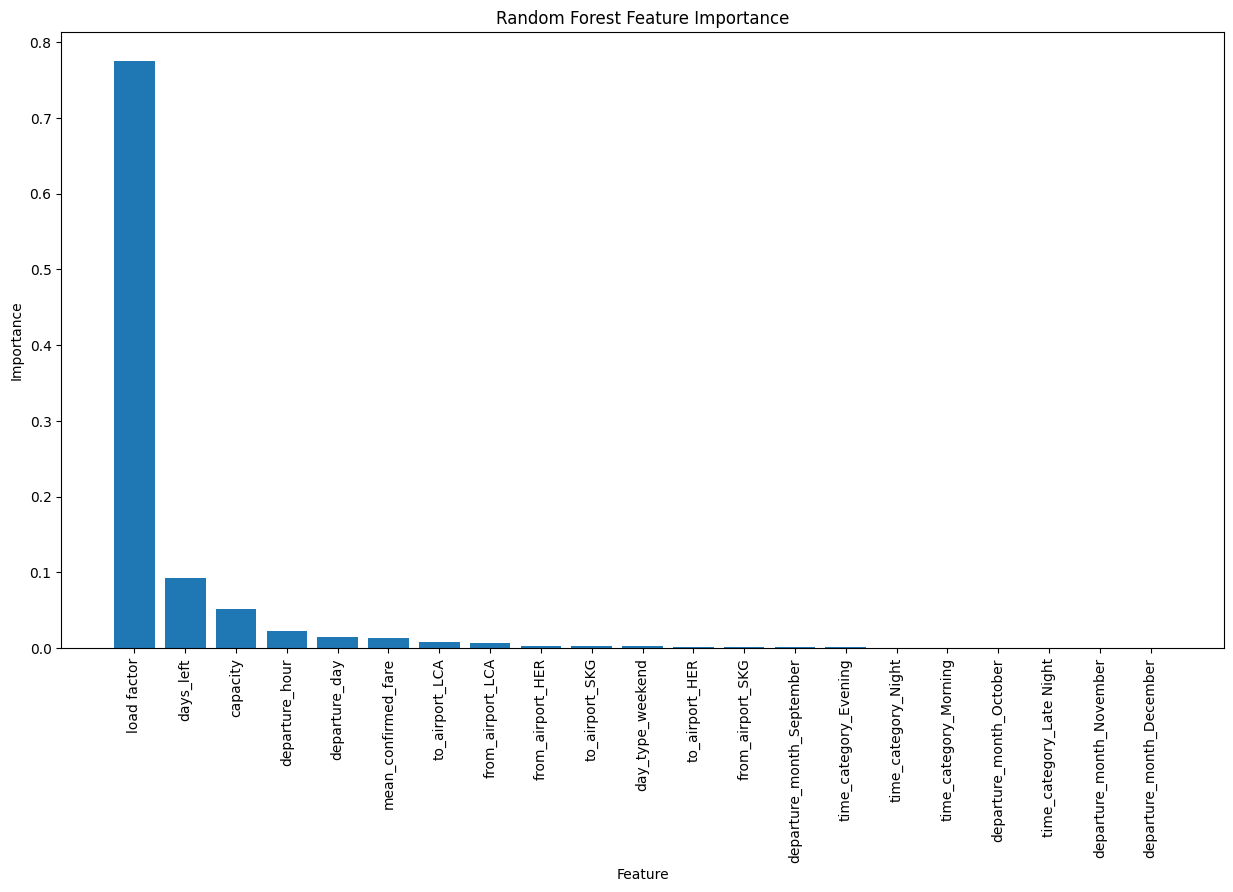

In [ ]:
# Assuming you've already run your code above...
# Extract the RandomForest model from the pipeline after training
random_forest_model = models['Random Forest']

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get one-hot encoded feature names
ohe_feature_names = (model_pipeline.named_steps['preprocessor']
                                 .named_transformers_['cat']
                                 .named_steps['onehot']
                                 .get_feature_names_out(categorical_cols))

# Combine numerical and one-hot encoded feature names
all_feature_names = numerical_cols + list(ohe_feature_names)

# Create a DataFrame for the feature importances
feature_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_df = feature_df.sort_values(by='Importance', ascending=False)


# Plot the feature importances
plt.figure(figsize=(15, 8))
plt.bar(feature_df['Feature'], feature_df['Importance'])
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


In [ ]:
# train without day type(weekday/weekend)
# Split data into features and target
X_features = merged_cr[['from_airport','to_airport','departure_hour','departure_day','time_category','departure_month','days_left','cumulative number of seats booked','capacity','mean_confirmed_fare','load factor','day_type','conversion ratio']]
y_target = merged_cr['cumulative number of bookings']

# Define numerical and categorical columns
numerical_cols = ['capacity', 'days_left', 'mean_confirmed_fare', 'departure_day','departure_hour','load factor','conversion ratio']
categorical_cols = ['to_airport', 'from_airport', 'departure_month','time_category','day_type']


# Preprocessing: Create transformers for numerical and categorical columns
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the final pipeline for each model
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor()
}

results = []

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

original_rows_X_test = merged_cr.loc[X_test.index]

for model_name, model in models.items():
    # Create a full pipeline with the preprocessor and the model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Fit the model to the training data
    model_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_pipeline.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([model_name, mse, r2])


# Create a table to display the results
table = tabulate(results, headers=['Model', 'MSE', 'R2 Score'], tablefmt='pretty')


# Print the table
print(table)

+-------------------+--------------------+--------------------+
|       Model       |        MSE         |      R2 Score      |
+-------------------+--------------------+--------------------+
| Linear Regression | 73.57987161947135  | 0.851177257967708  |
|   Random Forest   | 9.308585695145831  | 0.9811724427196803 |
| Lasso Regression  | 84.57722353206691  | 0.8289339999855423 |
|   Decision Tree   | 20.034319282696075 | 0.959478560307623  |
+-------------------+--------------------+--------------------+


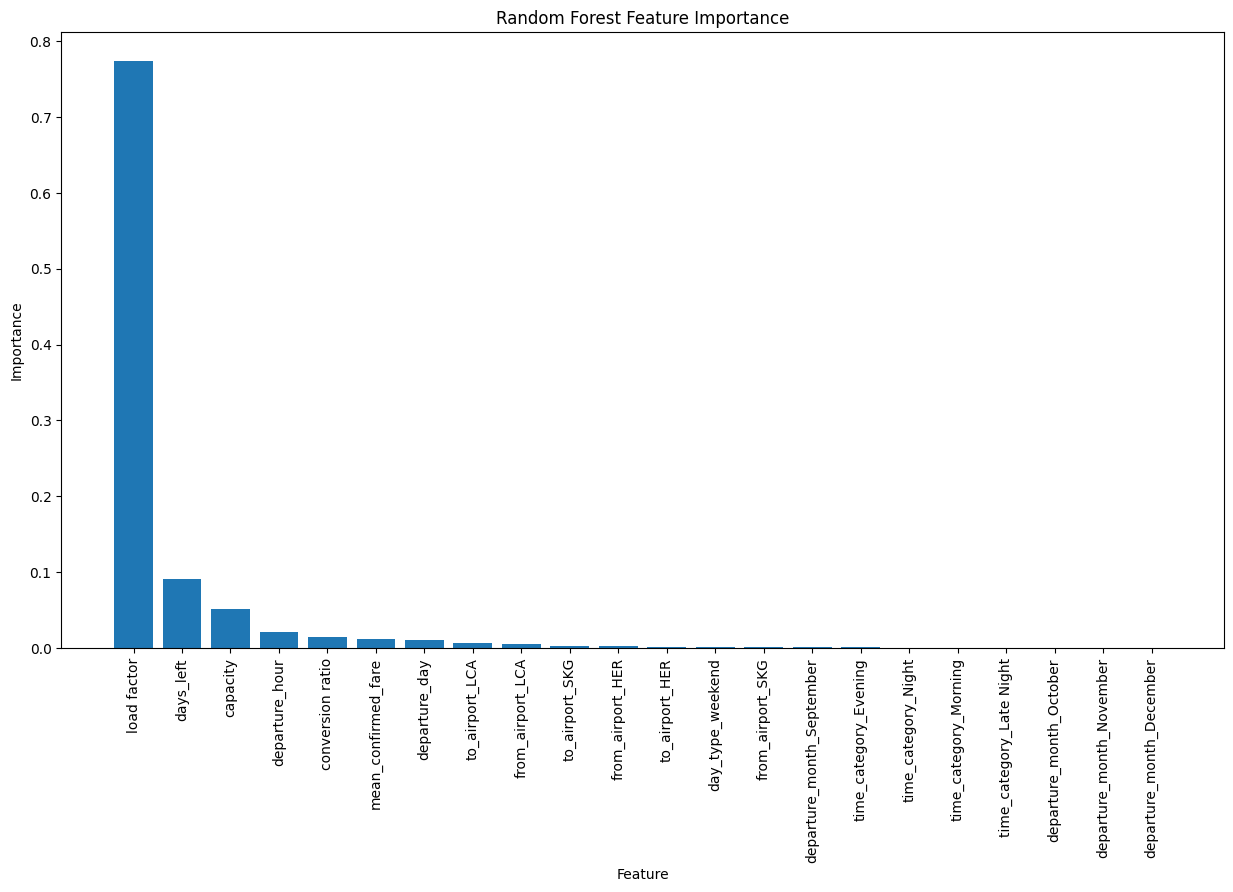

In [ ]:
# Assuming you've already run your code above...
# Extract the RandomForest model from the pipeline after training
random_forest_model = models['Random Forest']

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get one-hot encoded feature names
ohe_feature_names = (model_pipeline.named_steps['preprocessor']
                                 .named_transformers_['cat']
                                 .named_steps['onehot']
                                 .get_feature_names_out(categorical_cols))

# Combine numerical and one-hot encoded feature names
all_feature_names = numerical_cols + list(ohe_feature_names)

# Create a DataFrame for the feature importances
feature_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_df = feature_df.sort_values(by='Importance', ascending=False)


# Plot the feature importances
plt.figure(figsize=(15, 8))
plt.bar(feature_df['Feature'], feature_df['Importance'])
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


In [ ]:
average_grossfare = pd.read_csv('/content/drive/MyDrive/airline_data/average_grossfare.csv')
average_grossfare

,Outbound_Airline_Code,DepartureDate,SourceAirport,DestinationAirport,AverageGrossFare
0,A3,2023-05-03,ATH,HER,88.823182
1,A3,2023-05-03,ATH,SKG,128.125152
2,A3,2023-05-03,HER,ATH,72.166000
3,A3,2023-05-03,SKG,ATH,99.745312
4,A3,2023-05-04,ATH,HER,88.432500
...,...,...,...,...,...
3197,V7,2023-12-17,HER,ATH,49.990000
3198,V7,2023-12-18,ATH,HER,42.990000
3199,V7,2023-12-18,HER,ATH,49.990000
3200,V7,2023-12-20,ATH,HER,42.990000


In [ ]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tabulate import tabulate


# Train the Random Forest model and generate the SHAP plot
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

rf_pipeline.fit(X_train, y_train)

# Extract the trained Random Forest model and its feature names
rf_model = rf_pipeline.named_steps['model']
ohe = (rf_pipeline.named_steps['preprocessor']
       .named_transformers_['cat']
       .named_steps['onehot'])
feature_names = (numerical_cols +
                 list(ohe.get_feature_names_out(input_features=categorical_cols)))
# Preprocess X_test using only the preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

# Using the SHAP library, compute SHAP values for the Random Forest model
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_test_preprocessed)

# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)



In [ ]:
explainer

In [ ]:
# train without day type(weekday/weekend)
# Split data into features and target
X_features = merged_df[['from_airport','to_airport','departure_hour','departure_day','time_category','departure_month','days_left','cumulative number of seats booked','capacity','mean_confirmed_fare','load factor','day_type','competitorAverageGrossFare']]
y_target = merged_df['cumulative number of bookings']

# Define numerical and categorical columns
numerical_cols = ['capacity', 'days_left', 'mean_confirmed_fare', 'departure_day','departure_hour','load factor','competitorAverageGrossFare']
categorical_cols = ['to_airport', 'from_airport', 'departure_month','time_category','day_type']

# Preprocessing: Create transformers for numerical and categorical columns
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))  # Use drop='first' to prevent multicollinearity
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the final pipeline for each model
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor()
}

results = []

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)


for model_name, model in models.items():
    # Create a full pipeline with the preprocessor and the model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Fit the model to the training data
    model_pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_pipeline.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([model_name, mse, r2])


# Create a table to display the results
table = tabulate(results, headers=['Model', 'MSE', 'R2 Score'], tablefmt='pretty')


# Print the table
print(table)

+-------------------+--------------------+--------------------+
|       Model       |        MSE         |      R2 Score      |
+-------------------+--------------------+--------------------+
| Linear Regression |  55.9803173488815  | 0.8909232999389969 |
|   Random Forest   | 6.676165362063912  | 0.9869916048846755 |
| Lasso Regression  | 66.34465147953681  | 0.8707285704547759 |
|   Decision Tree   | 13.588390501319262 | 0.9735232512922902 |
+-------------------+--------------------+--------------------+


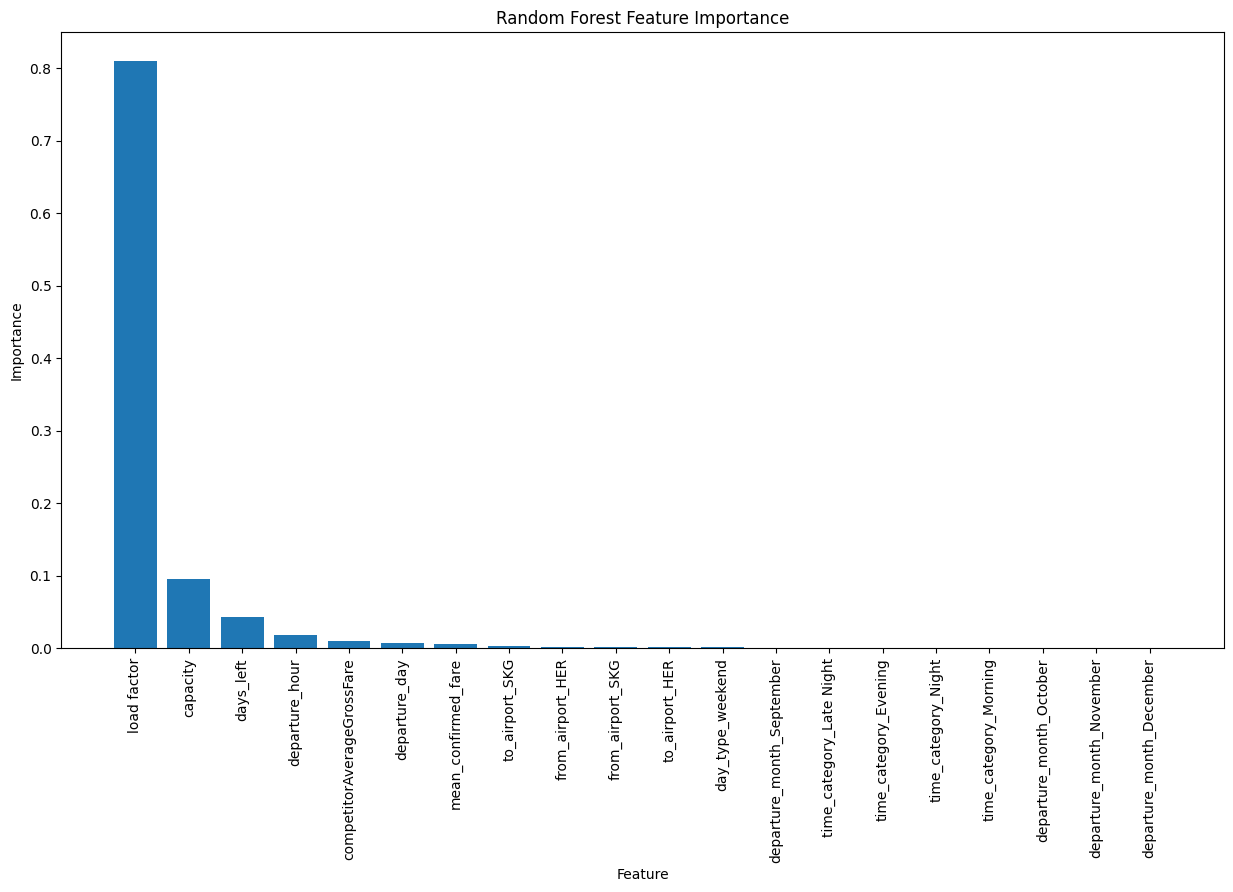

In [ ]:
# Assuming you've already run your code above...
# Extract the RandomForest model from the pipeline after training
random_forest_model = models['Random Forest']

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get one-hot encoded feature names
ohe_feature_names = (model_pipeline.named_steps['preprocessor']
                                 .named_transformers_['cat']
                                 .named_steps['onehot']
                                 .get_feature_names_out(categorical_cols))

# Combine numerical and one-hot encoded feature names
all_feature_names = numerical_cols + list(ohe_feature_names)

# Create a DataFrame for the feature importances
feature_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_df = feature_df.sort_values(by='Importance', ascending=False)


# Plot the feature importances
plt.figure(figsize=(15, 8))
plt.bar(feature_df['Feature'], feature_df['Importance'])
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()
